# Automated CapsnetsS2I train + test

First, import stuff

In [7]:
import model_s2i
import data_loader
import tensorflow as tf

In [8]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [13]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'vec-100'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice-cc-100.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
###############################################################
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
###############################################################
#         '../data-capsnets/diacritics_mixed_1/scenario0/train.txt',
#         '../data-capsnets/diacritics_mixed_1/scenario1/train.txt',
#         '../data-capsnets/diacritics_mixed_1/scenario2/train.txt',
#         '../data-capsnets/diacritics_mixed_1/scenario31/train.txt',
#         '../data-capsnets/diacritics_mixed_1/scenario32/train.txt',
#         '../data-capsnets/diacritics_mixed_1/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
###############################################################
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
###############################################################
#     '../data-capsnets/diacritics_mixed_1/scenario0/test.txt',
#     '../data-capsnets/diacritics_mixed_1/scenario1/test.txt',
#     '../data-capsnets/diacritics_mixed_1/scenario2/test.txt',
#     '../data-capsnets/diacritics_mixed_1/scenario31/test.txt',
#     '../data-capsnets/diacritics_mixed_1/scenario32/test.txt',
#     '../data-capsnets/diacritics_mixed_1/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [14]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.05
------------------load word2vec end---------------------


# Flag setting functions + utils

In [16]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    tf.app.flags.DEFINE_string('confidence_dir', './conf_levels/', 'Confidence levels analysis dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 16

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 8, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 10, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 3, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [15]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-vec-100-alpha-0001
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.023355
Accuracy: 0.015714
------------------epoch :  0  Loss:  26.534452 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.295238
F score 0.295238
Slot filling
F1 score: 0.080000
Accuracy: 0.895714
Current F score mean 0.18761904761904763
Best F score mean 0.18761904761904763
------------------epoch :  1  Loss:  12.903587 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.619048
F score 0.619048
Slot filli

------------------epoch :  5  Loss:  0.21288306 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.914286
F score 0.914286
Slot filling
F1 score: 0.878000
Accuracy: 0.985714
Current F score mean 0.8961428571428571
Best F score mean 0.9947527286776779
------------------epoch :  6  Loss:  0.1299127 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.938095
F score 0.938095
Slot filling
F1 score: 0.896000
Accuracy: 0.989048
Current F score mean 0.9170476190476191
Best F score mean 0.9947527286776779
------------------epoch :  7  Loss:  0.1609782 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.947619
F score 0.947619
Slot filling
F1 score: 0.936428
Accuracy: 0.993175
Current F score mean 0.9420234491374754
Best F score mean 0.9947527286776779
------------------epoch :  8  Loss:  0.031708997 ----------------------
           VALIDAT

------------------epoch :  11  Loss:  0.026779976 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.987780
Accuracy: 0.998571
Current F score mean 0.9926995441761226
Best F score mean 0.9947527286776779
------------------epoch :  12  Loss:  0.023322016 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.987780
Accuracy: 0.998571
Current F score mean 0.9938900203665988
Best F score mean 0.9947527286776779
------------------epoch :  13  Loss:  0.02088619 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.987780
Accuracy: 0.998571
Current F score mean 0.9938900203665988
Best F score mean 0.9947527286776779
------------------epoch :  14  Loss:  0.019268535 ----------------------
          

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.982671
Accuracy: 0.998129
Current F score mean 0.9889544196883646
Best F score mean 0.9889544196883646
------------------epoch :  12  Loss:  0.027037323 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.983707
Accuracy: 0.998299
Current F score mean 0.989472408107846
Best F score mean 0.989472408107846
------------------epoch :  13  Loss:  0.022156954 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.985743
Accuracy: 0.998469
Current F score mean 0.9904907380467463
Best F score mean 0.9904907380467463
------------------epoch :  14  Loss:  0.020393321 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995

------------------epoch :  18  Loss:  0.012404241 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.988878
Accuracy: 0.998980
Current F score mean 0.9932483509076027
Best F score mean 0.9932483509076027
------------------epoch :  19  Loss:  0.011800338 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.988878
Accuracy: 0.998980
Current F score mean 0.9932483509076027
Best F score mean 0.9932483509076027
FOLD 3
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.011437
Accuracy: 0.102721
------------------epoch :  0  Loss:  23.978733 ----------------------
           VALIDATION SET PERFORMANCE        


Intent F1: 0.607143
Slot F1: 0.780077
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-vec-100-alpha-0001
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.105556
F score 0.105556
Slot filling
F1 score: 0.028708
Accuracy: 0.149008
------------------epoch :  0  Loss:  29.911484 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.433333
F score 0.433333
Slot filling
F1 score: 0.047782
Accuracy: 0.883730
Current F score mean 0.24055745164960182
Best F score mean 0.24055745164960182
------------------epoch :  1  Loss:  13.005341 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accurac

------------------epoch :  5  Loss:  0.167458 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.967213
Accuracy: 0.997421
Current F score mean 0.9836065573770492
Best F score mean 0.9978858350951374
------------------epoch :  6  Loss:  0.20639548 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.983505
Accuracy: 0.998810
Current F score mean 0.9917525773195877
Best F score mean 0.9978858350951374
------------------epoch :  7  Loss:  0.08807135 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997222
F score 0.997222
Slot filling
F1 score: 0.980433
Accuracy: 0.998611
Current F score mean 0.9888273829957661
Best F score mean 0.9978858350951374
------------------epoch :  8  Loss:  0.06626473 ----------------------
           VALIDATI

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993902
Accuracy: 0.999405
Current F score mean 0.9969512195121951
Best F score mean 0.9978858350951374
------------------epoch :  12  Loss:  0.047063023 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.993902
Accuracy: 0.999405
Current F score mean 0.9969512195121951
Best F score mean 0.9978858350951374
------------------epoch :  13  Loss:  0.044462398 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.995935
Accuracy: 0.999603
Current F score mean 0.9979674796747968
Best F score mean 0.9979674796747968
------------------epoch :  14  Loss:  0.042454693 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.0

------------------epoch :  12  Loss:  0.047625855 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.977712
Accuracy: 0.998168
Current F score mean 0.9808430487293786
Best F score mean 0.9824456128319428
------------------epoch :  13  Loss:  0.041312642 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.977712
Accuracy: 0.998168
Current F score mean 0.9808430487293786
Best F score mean 0.9824456128319428
------------------epoch :  14  Loss:  0.037067275 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.977712
Accuracy: 0.998168
Current F score mean 0.9808430487293786
Best F score mean 0.9824456128319428
------------------epoch :  15  Loss:  0.034497574 ----------------------
         

------------------epoch :  18  Loss:  0.02948231 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.987915
Accuracy: 0.999084
Current F score mean 0.9859448834146719
Best F score mean 0.9874554574327987
------------------epoch :  19  Loss:  0.033963148 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977564
F score 0.977564
Slot filling
F1 score: 0.990937
Accuracy: 0.999313
Current F score mean 0.9842503292276705
Best F score mean 0.9874554574327987
FOLD 3
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.096154
F score 0.096154
Slot filling
F1 score: 0.008934
Accuracy: 0.004808
------------------epoch :  0  Loss:  25.92361 ----------------------
           VALIDATION SET PERFORMANCE        
In

Intent F1: 0.425000
Slot F1: 0.680532
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-vec-100-alpha-0001
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.008850
F score 0.008850
Slot filling
F1 score: 0.032170
Accuracy: 0.226717
------------------epoch :  0  Loss:  28.29227 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.262537
F score 0.262537
Slot filling
F1 score: 0.191176
Accuracy: 0.932575
Current F score mean 0.22685667187228875
Best F score mean 0.22685667187228875
------------------epoch :  1  Loss:  14.272216 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accurac

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.905605
F score 0.905605
Slot filling
F1 score: 0.910828
Accuracy: 0.990308
Current F score mean 0.9082163726208594
Best F score mean 0.9805070557282947
------------------epoch :  5  Loss:  0.20481041 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.943953
F score 0.943953
Slot filling
F1 score: 0.962382
Accuracy: 0.995786
Current F score mean 0.9531676237504738
Best F score mean 0.9805070557282947
------------------epoch :  6  Loss:  0.10352017 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985251
F score 0.985251
Slot filling
F1 score: 0.963893
Accuracy: 0.995154
Current F score mean 0.9745719935353311
Best F score mean 0.9805070557282947
------------------epoch :  7  Loss:  0.10599959 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994100


------------------epoch :  11  Loss:  0.29178178 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994100
F score 0.994100
Slot filling
F1 score: 0.967262
Accuracy: 0.996839
Current F score mean 0.9806810998735778
Best F score mean 0.9897959183673469
------------------epoch :  12  Loss:  0.10628091 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994100
F score 0.994100
Slot filling
F1 score: 0.955621
Accuracy: 0.996418
Current F score mean 0.9748607983801993
Best F score mean 0.9897959183673469
------------------epoch :  13  Loss:  0.041420437 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994100
F score 0.994100
Slot filling
F1 score: 0.971684
Accuracy: 0.997472
Current F score mean 0.9828921743182588
Best F score mean 0.9897959183673469
------------------epoch :  14  Loss:  0.03602349 ----------------------
           V

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987013
F score 0.987013
Slot filling
F1 score: 0.961538
Accuracy: 0.993506
Current F score mean 0.9742757242757243
Best F score mean 0.9742757242757243
------------------epoch :  12  Loss:  0.079525545 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987013
F score 0.987013
Slot filling
F1 score: 0.961538
Accuracy: 0.993506
Current F score mean 0.9742757242757243
Best F score mean 0.9742757242757243
------------------epoch :  13  Loss:  0.06047167 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987013
F score 0.987013
Slot filling
F1 score: 0.960110
Accuracy: 0.994125
Current F score mean 0.9735615141392308
Best F score mean 0.9742757242757243
------------------epoch :  14  Loss:  0.050200738 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98

------------------epoch :  18  Loss:  0.03891078 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.978355
F score 0.978355
Slot filling
F1 score: 0.990345
Accuracy: 0.998145
Current F score mean 0.9843499029705927
Best F score mean 0.9843499029705927
------------------epoch :  19  Loss:  0.035904065 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.978355
F score 0.978355
Slot filling
F1 score: 0.990345
Accuracy: 0.998145
Current F score mean 0.9843499029705927
Best F score mean 0.9843499029705927
FOLD 3
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.012987
F score 0.012987
Slot filling
F1 score: 0.021164
Accuracy: 0.019790
------------------epoch :  0  Loss:  39.209152 ----------------------
           VALIDATION SET PERFORMANCE        
I

Intent F1: 0.413238
Slot F1: 0.482484


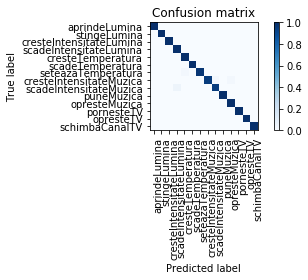

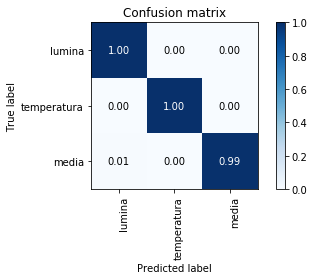

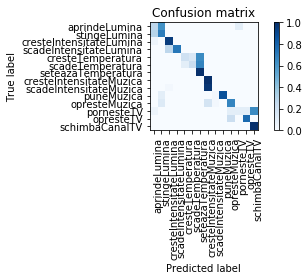

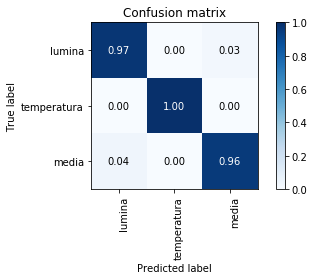

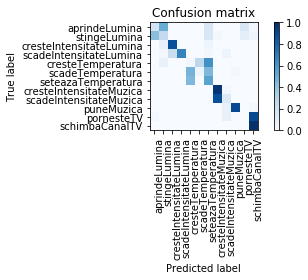

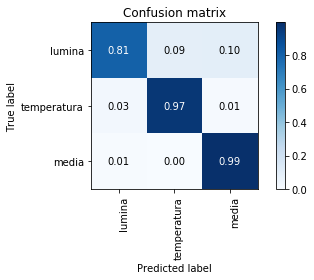

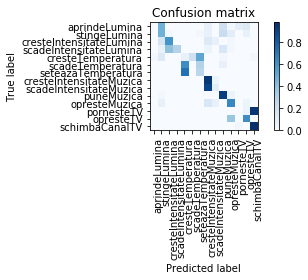

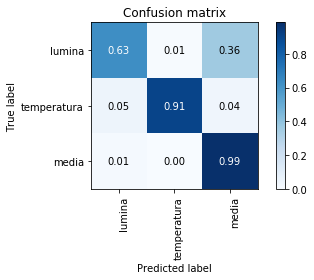

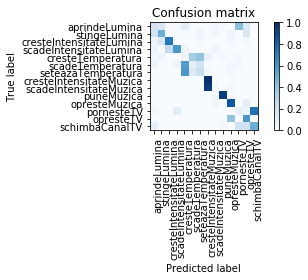

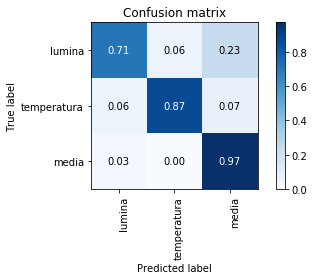

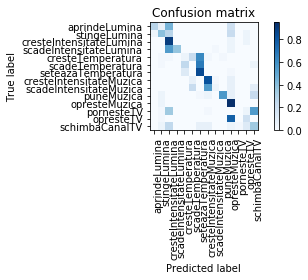

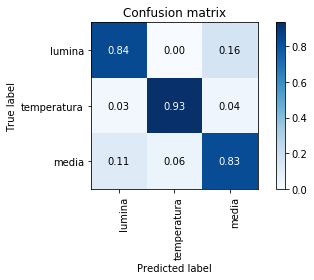

In [17]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    isLowercase = False # When using the new 100-dim word vec model (conll, not fasttext), the data should all be in lowercase
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True, lowercase=isLowercase)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False, log=True)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)